In [1]:
import numpy as np
import pandas as pd 
from random import sample
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
# dynamic time warping
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# load data
sales = pd.read_csv("sales_train_validation.csv")

In [3]:
sales.loc[sales.item_id == 'HOBBIES_1_001']\
    .sort_values("id")\
    .head()

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
3049   HOBBIES_1_001_CA_2_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
6098   HOBBIES_1_001_CA_3_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
9147   HOBBIES_1_001_CA_4_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
12196  HOBBIES_1_001_TX_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  \
0         CA_1       CA    0    0    0    0  ...       1       3       0   
3049      CA_2       CA    0    0    0    0  ...       0       0       1   
6098      CA_3       CA    0    0    0    0  ...       0       2       4   
9147      CA_4       CA    0    0    0    0  ...       1       0       0   
12196     TX_1       TX    0    0    0    0  ...       0       0       0   

       d_1907  d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
0           1       1       1       3       0       1       1  
3049        2       0       4       0       0       2       2  
6098        0       1       1       1       0       3       3  
9147        1       0       1       0       1       2       1  
12196       0       1       0       1       0       0       2  

[5 rows x 1919 columns]

In [4]:
_cols = list(sales.columns)
sales.columns = pd.Index(_cols[:6] + [int(c.replace("d_","")) for c in _cols[6:]])
del _cols

In [5]:
#Functions for isolating particular...
#item_id's (combination of item and store)
#items (aggregated over stores)
#departments (aggregated over items and stores)

In [6]:
def series_from_id(_id:str) -> pd.DataFrame:
    """
    Get a daily time series for a single id
    """
    return sales.loc[sales.id == _id]\
    .iloc[:,6:]\
    .T

# Create a global lookup table for fast plotting by department
daily_sales_dept_lookup = sales[["dept_id"] + list(sales.columns[6:])]\
    .melt(id_vars = "dept_id")\
    .groupby("dept_id variable".split())\
    .agg({"value":"sum"})

def series_from_dept(dept:str) -> pd.DataFrame:
    return daily_sales_dept_lookup.loc[dept]

# create a global lookup table for fast plotting by item
daily_sales_item_lookup = sales[["item_id"] + list(sales.columns[6:])]\
    .melt(id_vars = "item_id")\
    .groupby("item_id variable".split())\
    .agg({"value":"sum"})

def series_from_item(item:str) -> pd.DataFrame:
    return daily_sales_item_lookup.loc[item]

"""
Time series for particular items are quite noisy on a daily level. 
Provide the ability to bin sales (for examply - to a weekly bin) for more stable plots
"""
def series_from_id_binned(_id:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for an id, grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_id(_id).reset_index()
    t["index"] = t.index.map(lambda x: x - (x % bin_every))
    t.columns = pd.Index(["day", "sales"])
    return t.groupby("day")\
        .agg({"sales":"sum"})

def series_from_dept_binned(dept:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for a department, grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_dept(dept).reset_index()
    t["variable"] = t.index.map(lambda x: x - (x % bin_every))
    return t.groupby("variable")\
        .agg({"value":"sum"})

def series_from_item_binned(item:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for an item (across stores), grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_item(item).reset_index()
    t["variable"] = t.index.map(lambda x: x - (x % bin_every))
    return t.groupby("variable")\
        .agg({"value":"sum"})

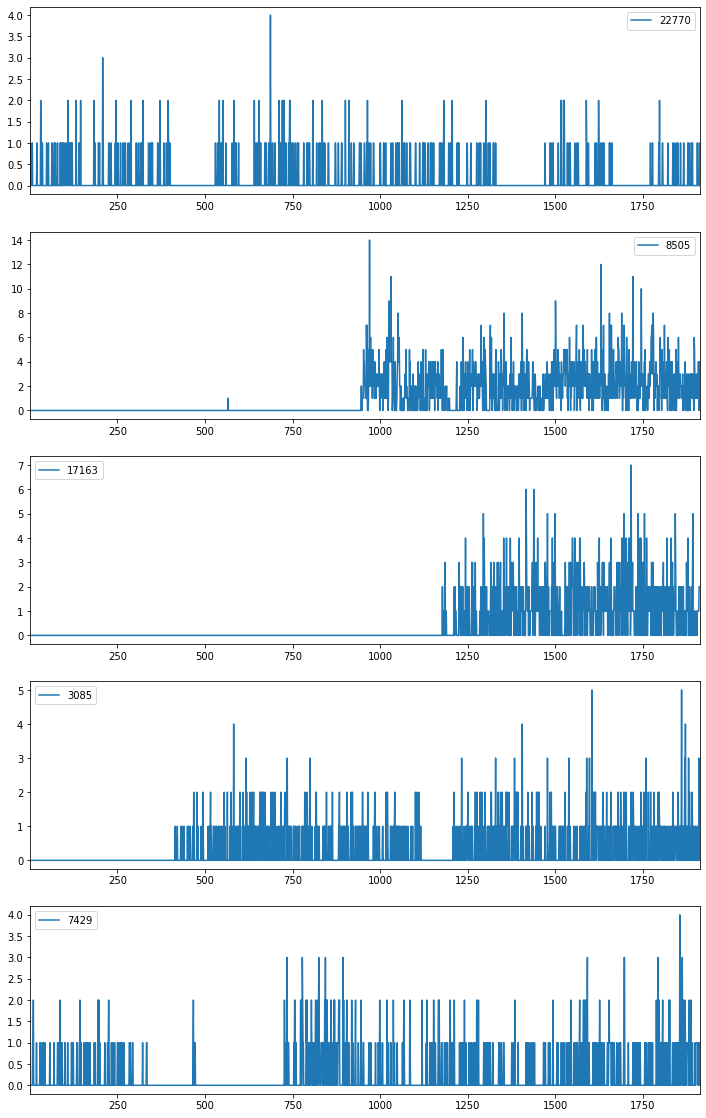

In [7]:
#Plotting 5 unique items (id's)
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
_ids = sales["id"].sample(n = 5, random_state = 1)
for i in range(len(_ids)):
    series_from_id(_ids.iloc[i]).plot(ax = axes[i])
del _ids

In [8]:
#We see some clear differences in the series shapes - 
#some have traffic all throughout while others don't start until later on
#Plus the scale is different. The first series gets 1-2 sales a day, 
#while the second gets 2-6 (after a period of relative quiet)
#To avoid dealing with very noisy series, I'll bin sales by week, 
#which will remove weekly seasonality and lead the number of sales per time unit to be less volitile.

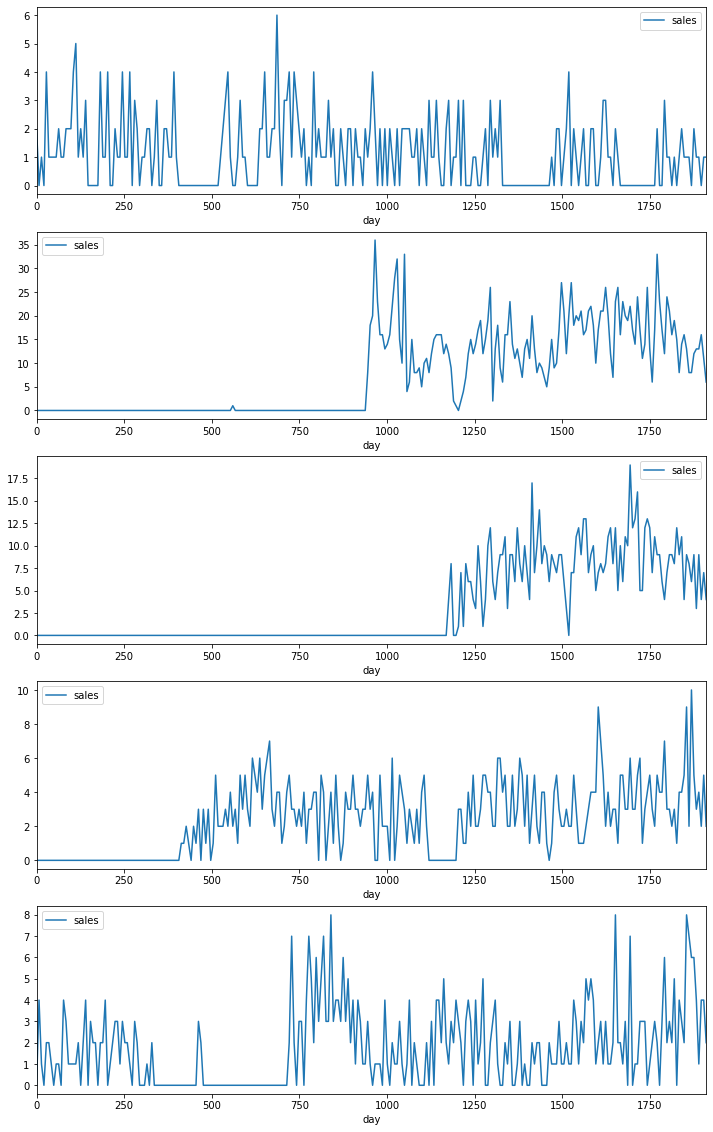

In [9]:
# bin the items by week and plot again
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
_ids = sales["id"].sample(n = 5, random_state = 1)
for i in range(len(_ids)):
    series_from_id_binned(_ids.iloc[i], bin_every = 7).plot(ax = axes[i])

In [10]:
#For the first and second series, sales only start at a certain point, 
#and then they are quite strong. 
#This is probably because these items were introduced by Walmart sometime during this time period.
#This is important, as if we are to train a model over the entire time period, 
#then we will dilute any real signal with a period of zero sales. 
#Instead, we need a way to clip the begining of the series that has no sales, 
#and only start training after the point that we have data.

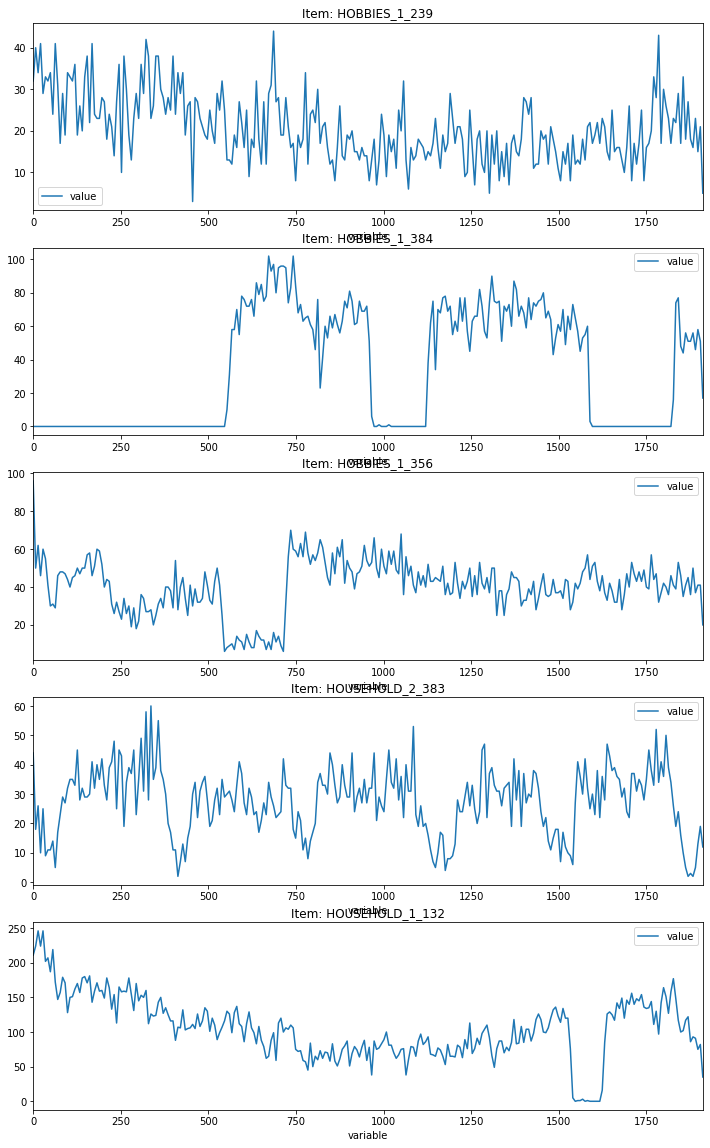

In [11]:
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
random.seed(2)
_ids = sample(list(sales["item_id"].unique()), 5)
for i in range(len(_ids)):
    series_from_item_binned(_ids[i], bin_every = 7).plot(ax = axes[i])
    axes[i].set_title("Item: %s" % _ids[i])

In [12]:
#It's clear that there are some interventions that Walmart makes - 
#as sales may dip all of a sudden quite dramatically. For example, 
#it looks like after months of steady sales, sales dip for the first item plotted above - 
#maybe because they're taken off the shelves at one or more store.
#Similarly, the last chart shows that an item may be introduced
#and then removed from the shelves on a periodic basis.
#Predicting how volitile these series are will rely on identifying 
#which items are likely to have these types of interventions - a
#s a sudden decrease in sales may lead to high inter-quartile ranges for a period's sales.

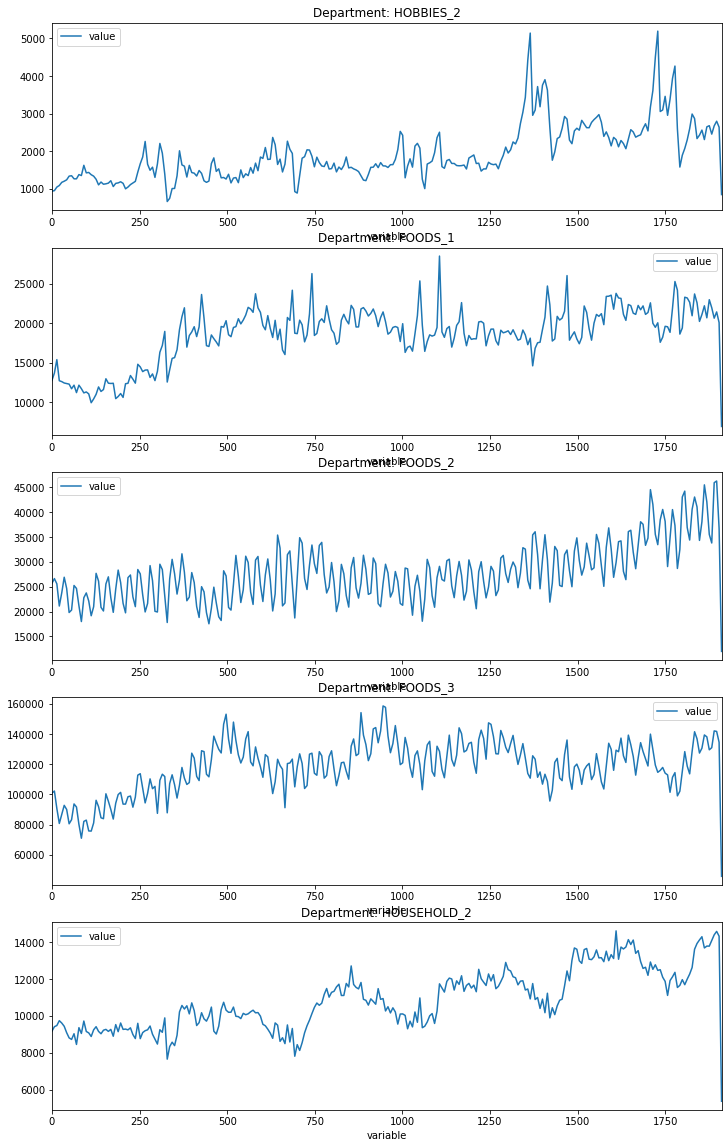

In [13]:
#Finally, plotting 5 randomly selected departments
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
random.seed(3)
_ids = sample(list(sales["dept_id"].unique()), 5)
for i in range(len(_ids)):
    series_from_dept_binned(_ids[i], bin_every = 7).plot(ax = axes[i])
    axes[i].set_title("Department: %s" % _ids[i])

In [14]:
#At the Department level, this starts to look like a time series that which are more straight forward to work with.
#We see clear trend, seasonal (monthly, as I'm binning by weeks as it is) and periodic components.

In [15]:
#Clustering entire departments together doesn't seeem sufficiently useful, 
#as there are only 7 departments - and could probably be forecasted individually.

#Clustering at the lowest level of granularity (item_id) would likely be very volitile,
#and sort of defeats the purpose of clustering items. 
#I want to understand what items are similar - both in terms of demand and how Walmart changes.
#Though it could be that demand and store strategies change between stores, 
#clustering items directly (independent of store) serves to achieve this purpose most directly.

#I'm also going to group by week, to remove weekly seasonality (for simplicity).
#This implicitly assumes that all items have similar weekly seasonality.

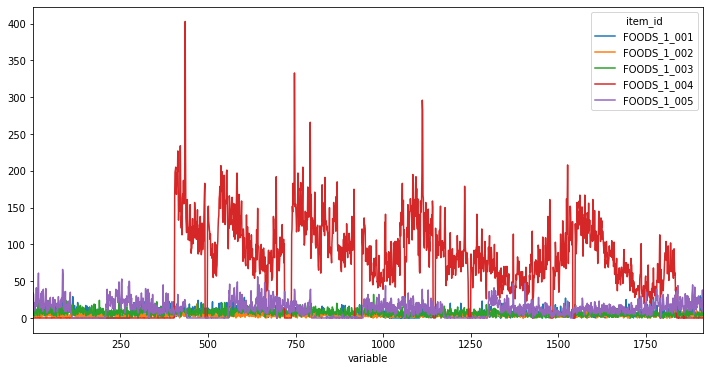

In [16]:
daily_sales_item_lookup.pivot_table(index = "variable", columns = "item_id", values = "value")\
    .iloc[:,:5]\
    .plot(figsize = (12,6))

In [17]:
#Some items are sold at a way higher rate than others. 
#When we cluster, we don't want the result of our clustering to split popular vs unpopular items.
#Rather, we're interested in distinguishing the shape between items.

#Thus, I'll rescale each item according to it's global mean.

In [18]:
# Create a lookup table for scaled series
daily_sales_item_lookup_scaled = daily_sales_item_lookup\
    .pivot_table(index = "variable", columns = "item_id", values = "value").copy()
daily_sales_item_lookup_scaled = daily_sales_item_lookup_scaled.div(daily_sales_item_lookup_scaled.mean(axis = 0), axis = 1)
# bin by week
daily_sales_item_lookup_scaled_weekly = daily_sales_item_lookup_scaled.copy().reset_index()
daily_sales_item_lookup_scaled_weekly["variable"] = daily_sales_item_lookup_scaled_weekly.variable.map(lambda x: x - (x%7))
daily_sales_item_lookup_scaled_weekly = daily_sales_item_lookup_scaled_weekly.groupby("variable").mean()

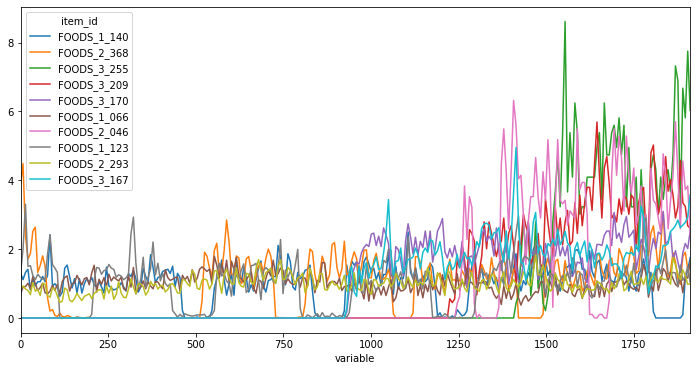

In [19]:
# plot those same series, but this time normalized by the series' means. 
random.seed(1)
daily_sales_item_lookup_scaled_weekly.iloc[:,random.sample(range(1000),10)]\
    .plot(figsize = (12,6))

In [20]:
#As a quick and dirty first approach I'll cluster the series using a simple Heirarchical Clustering method. 
#To do so, we treat each time series as a vector of the same length,
#and cluster them as we would any other set of vectors.

#In this way, we're grouping together series that behave similar at the same points in time.
#This method does not recognize shifts in otherwise similar series, as I'll discuss later.

In [21]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, ward, dendrogram

In [22]:
clf = AgglomerativeClustering(n_clusters=4).fit(daily_sales_item_lookup_scaled_weekly.T.values)
daily_sales_item_lookup_scaled_clustered = daily_sales_item_lookup_scaled_weekly.T.reset_index()
daily_sales_item_lookup_scaled_clustered["cluster"] = clf.labels_
daily_sales_item_lookup_scaled_clustered = daily_sales_item_lookup_scaled_clustered.set_index("cluster item_id".split())\
    .sort_index()

In [23]:
df=daily_sales_item_lookup_scaled_clustered.reset_index()

In [24]:
df.shape

(3049, 276)

In [25]:
df.head()

variable  cluster      item_id    0    7   14   21   28   35   42   49  ...  \
0               0  FOODS_1_056  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1               0  FOODS_1_057  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2               0  FOODS_1_060  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3               0  FOODS_1_111  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4               0  FOODS_1_122  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

variable      1848      1855      1862      1869      1876      1883  \
0         0.000000  0.000000  0.000000  0.000000  0.000000  0.088989   
1         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2         2.894976  2.977689  3.225830  4.052966  3.804825  3.473971   
3         3.232679  2.611010  5.222020  3.854348  3.730014  3.357013   
4         2.593336  2.748936  4.771738  3.682537  4.875471  4.771738   

variable      1890      1897      1904      1911  
0         0.000000  0.000000  0.000000  0.415283  
1         0.073110  0.000000  0.000000  0.170590  
2         2.812262  2.812262  1.654272  1.543987  
3         3.978682  2.611010  3.481347  2.030786  
4         3.682537  5.082938  3.578803  4.477826  

[5 rows x 276 columns]

In [26]:
df['cluster'].value_counts()

1    1724
2     557
3     419
0     349
Name: cluster, dtype: int64

In [67]:
df.to_csv('cluster4.csv', index=False)

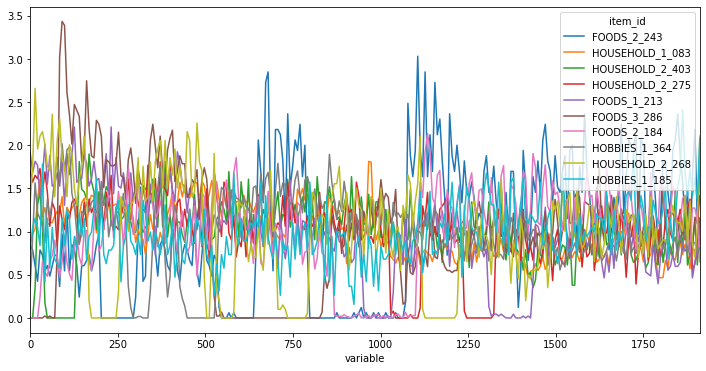

In [28]:
# cluster 1
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[1]\
    .T\
    .iloc[:, random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[1].shape[0]), 10)]\
    .plot(figsize = (12,6))

In [ ]:
#Cluster1 well this cluster doesn't tell a very clear story. 
#In the dendogram above, you'll see that the this cluster is the largest 
#and forms the widest terminal grouping, meaning that the series in this cluster
#are note found to be very well grouped together. In this way, cluster 1 is a sort of 
#"other" grouping, which would likely be the least helpful as a pre-processing step for modeling.

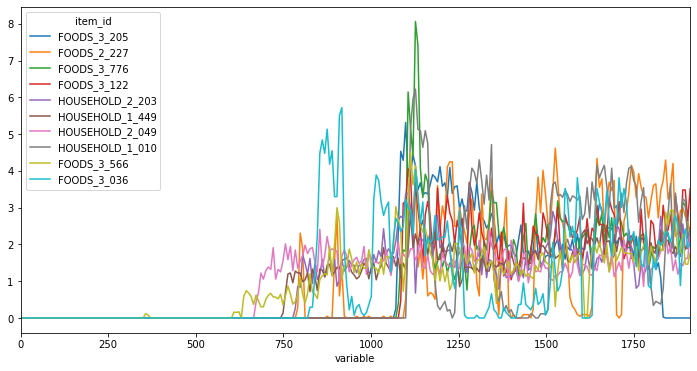

In [29]:
# series 2
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[2]\
    .T\
    .iloc[:, random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[2].shape[0]), 10)]\
    .plot(figsize = (12,6))

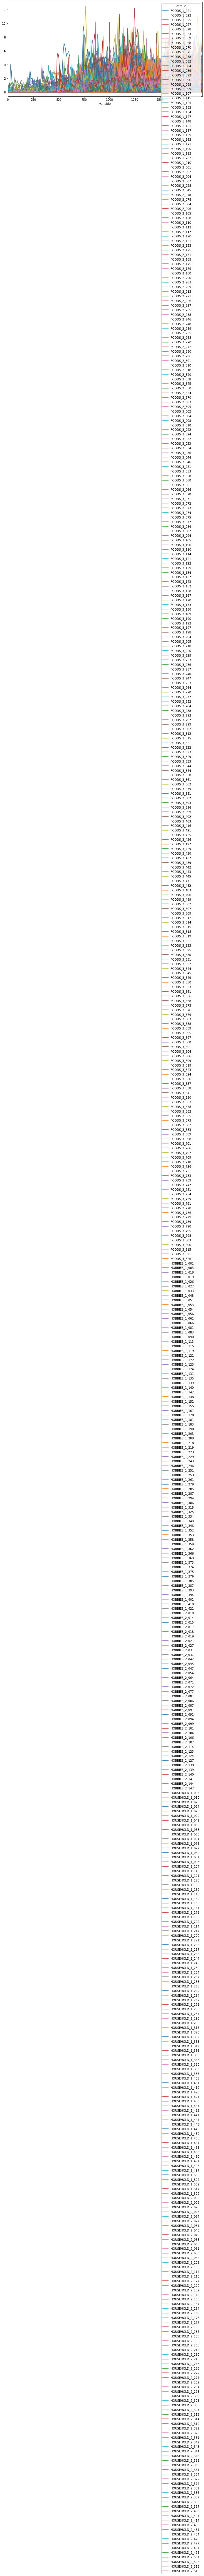

In [30]:
# series 2
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[2]\
    .T\
    .iloc[:, range(557)]\
    .plot(figsize = (12,6))

In [31]:
#The series in cluster 1 seem to be similar in that they start with very few sales up until day 500-700,
#and then have relatively steady sales past that point.

#The series in this cluster might be pre-processed in a similar way, by cutting off the first 500 days of data, 
#for example.

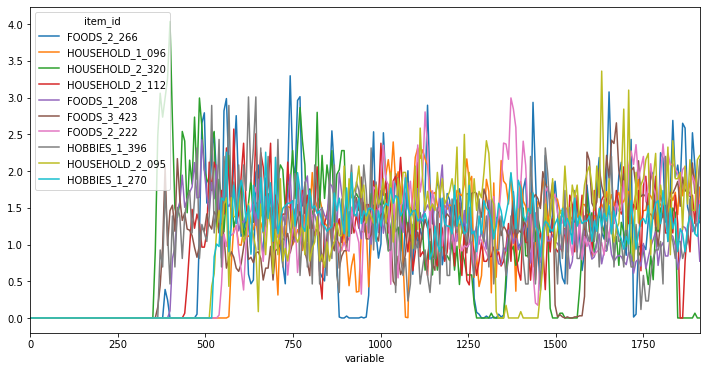

In [32]:
# cluster 3
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[3]\
    .T\
    .iloc[:, random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[3].shape[0]), 10)]\
    .plot(figsize = (12,6))

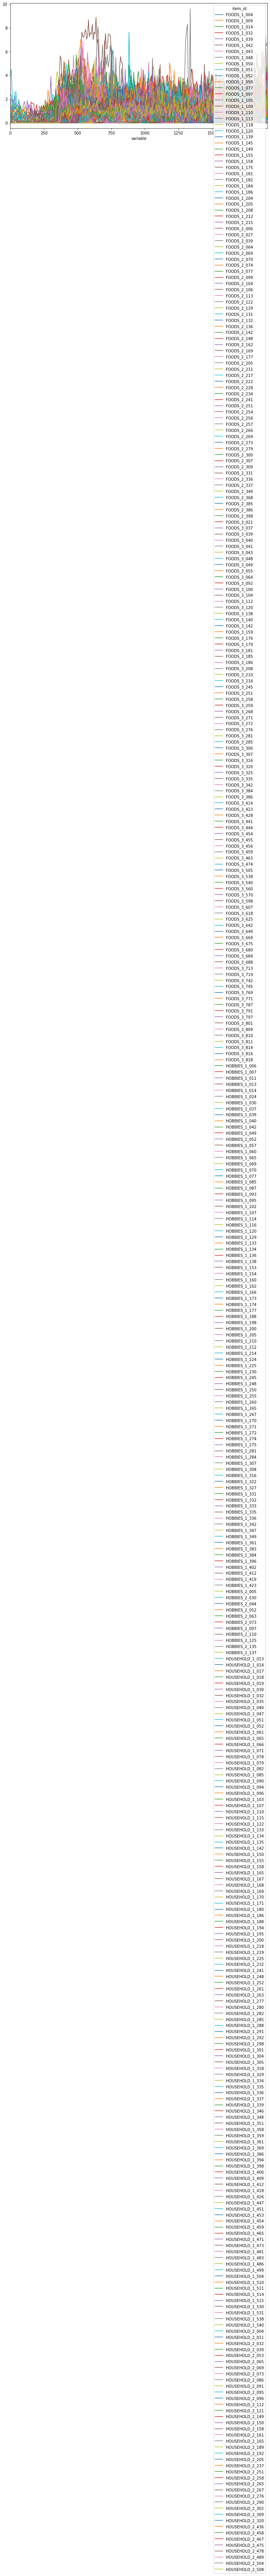

In [33]:
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[3]\
    .T\
    .iloc[:, range(419)]\
    .plot(figsize = (12,6))

In [36]:
#The series in cluster 3 seem to be similar in that they start with very few sales up until day 250-500,
#and then have relatively steady sales past that point.

#The series in this cluster might be pre-processed in a similar way, by cutting off the first 250 days of data, 
#for example.

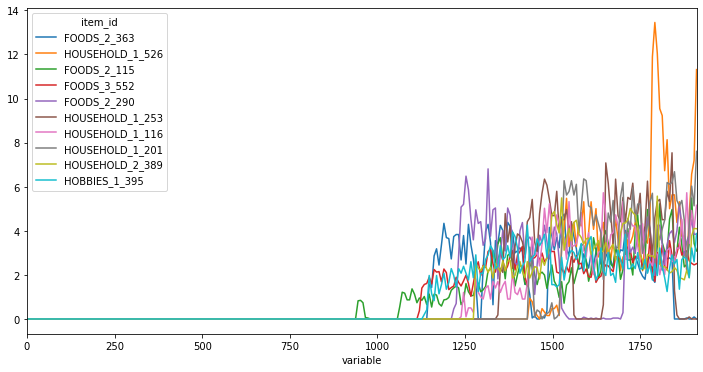

In [34]:
# cluster 0
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[0]\
    .T\
    .iloc[:, random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[0].shape[0]), 10)]\
    .plot(figsize = (12,6))

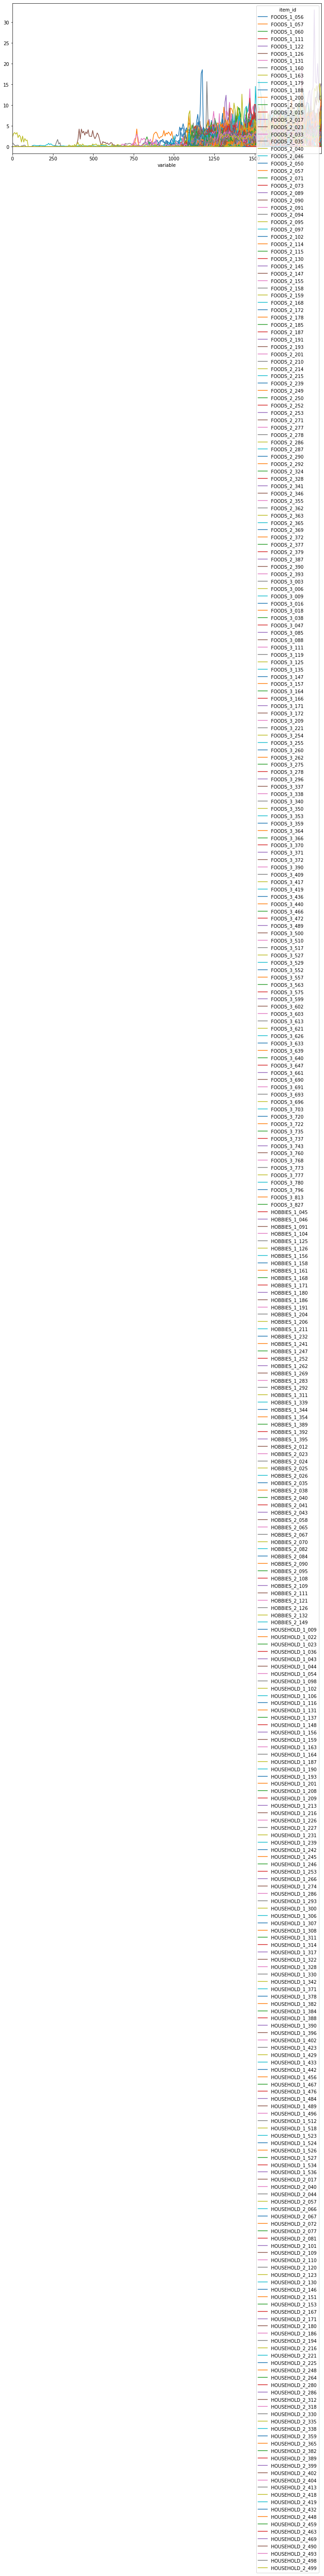

In [35]:
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[0]\
    .T\
    .iloc[:,range(349)]\
    .plot(figsize = (12,6))

In [36]:
#The series in cluster 3 seem to be similar in that they start with very few sales up until day 1000-1250,
#and then have relatively steady sales past that point.

#The series in this cluster might be pre-processed in a similar way, by cutting off the first 1000 days of data, 
#for example.